# AlongTrack Data

In [2]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ocn_tools._src.geoprocessing.validation import validate_latlon, validate_time, decode_cf_time, validate_ssh
from ocn_tools._src.preprocessing.alongtrack import alongtrack_ssh
from ocn_tools._src.geoprocessing.subset import where_slice
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


## Data Challenge - 2020a - OSSE


> This data challenge looks at some simulated Altimetry data from simulations

In [65]:
data_registry_dir = "/Volumes/EMANS_HDD/data/oceanbench-data-registry"

In [66]:
osse_dc20a_data_dir = f"{data_registry_dir}/osse_natl60/coord/nadirs"
!ls $osse_dc20a_data_dir

en.nc       g2.nc       j1.nc       swot.nc     tpn.nc
en.nc.dvc   g2.nc.dvc   j1.nc.dvc   swot.nc.dvc tpn.nc.dvc


In [48]:
file_dir = "/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs"
files_nadir_dc20a = [
    f"{file_dir}/en.nc",
    f"{file_dir}/g2.nc",
    f"{file_dir}/j1.nc",
    f"{file_dir}/tpn.nc",
    
]

In [49]:
def preprocess_nadir_dc20a(da):
    
    # change names
    # da = da.rename({"latitude": "lat", "longitude": "lon"})
    
    # reorganized
    da = da.sortby("time").compute()
    
    # validate coordinates
    da = validate_latlon(da)
    da = validate_time(da)
    # validate variables
    da = da.rename({"ssh_model": "ssh"})
    da = validate_ssh(da)
    
    # # slice time period
    # da = da.sel(time=slice("2012-10-22", "2012-12-03"))
    
    # # slice region
    # da = where_slice(da, "lon", -64.975, -55.007)
    # da = where_slice(da, "lat", 33.025, 42.9917)
    

    
    # assign coordinates
    da = da.set_coords(["time", "lat", "lon"])
    
    return da[["ssh"]]

In [50]:
ds_nadir = xr.open_mfdataset(
    files_nadir_dc20a, 
    preprocess=preprocess_nadir_dc20a,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time").compute()

ds_nadir

/Users/eman/miniconda3/envs/oceanbench_311/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 6086079)
Coordinates:
    lat      (time) float32 61.2 61.15 61.09 61.04 ... 42.66 42.6 42.54 42.48
    lon      (time) float32 -48.72 -48.76 -48.8 -48.84 ... 5.301 5.281 5.261
  * time     (time) datetime64[ns] 2012-10-01T00:40:35.094088 ... 2013-09-30T...
Data variables:
    ssh      (time) float32 -0.2923 -0.2958 -0.2954 ... -0.1164 -0.1165 -0.1232

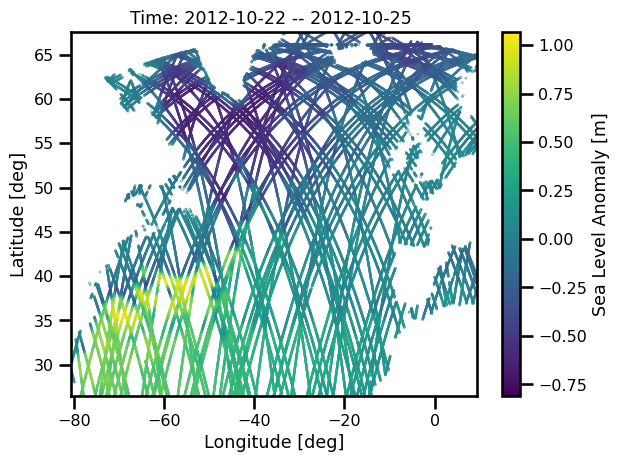

In [57]:
%matplotlib inline

fig, ax = plt.subplots()

t0 = "2012-10-22"
t1 = "2012-10-25"

sub_ds = ds_nadir.sel(time=slice(t0,t1))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude [deg]",
    ylabel="Latitude [deg]",
    xlim=[ds_nadir.lon.min(), ds_nadir.lon.max()],
    ylim=[ds_nadir.lat.min(), ds_nadir.lat.max()],
)

plt.colorbar(pts, label="Sea Level Anomaly [m]")
ax.set_title(f"Time: {t0} -- {t1} ")
plt.tight_layout()
plt.show()

## Data Challenge - 2021a - OSE

> This data challenge looks at some real altimetry data for sea surface height.

In [70]:
ose_dc21a_data_dir = f"{data_registry_dir}/ose/coord"
!ls $ose_dc21a_data_dir

gf_2017_l3_alg.nc     gf_2017_l3_h2g.nc.dvc gf_2017_l3_j3.nc
gf_2017_l3_alg.nc.dvc gf_2017_l3_j2g.nc     gf_2017_l3_j3.nc.dvc
gf_2017_l3_c2.nc      gf_2017_l3_j2g.nc.dvc gf_2017_l3_s3a.nc
gf_2017_l3_c2.nc.dvc  gf_2017_l3_j2n.nc     gf_2017_l3_s3a.nc.dvc
gf_2017_l3_h2g.nc     gf_2017_l3_j2n.nc.dvc


In [72]:
files_nadir_dc21a = [
    f"{ose_dc21a_data_dir}/gf_2017_l3_alg.nc",
    f"{ose_dc21a_data_dir}/gf_2017_l3_c2.nc",
    f"{ose_dc21a_data_dir}/gf_2017_l3_h2g.nc",
    f"{ose_dc21a_data_dir}/gf_2017_l3_j2g.nc",
    f"{ose_dc21a_data_dir}/gf_2017_l3_j3.nc",
    f"{ose_dc21a_data_dir}/gf_2017_l3_s3a.nc",
    
]

In [73]:
def preprocess_nadir_dc21a(da):
    
    # reorganized
    da = da.sortby("time").compute()
    
    # validate coordinates
    da = da.rename({"longitude": "lon", "latitude": "lat"})
    da = validate_latlon(da)
    da = validate_time(da)
    
    # # slice region
    # da = where_slice(da, "lon", -64.975, -55.007)
    # da = where_slice(da, "lat", 33.025, 42.9917)
    
    # # slice time period
    # da = da.sel(time=slice("2017-01-01", "2017-12-31"))
    
    # calculate SSH directly
    da = alongtrack_ssh(da)
    
    return da

In [74]:
ds_nadir = xr.open_mfdataset(
    files_nadir_dc21a, 
    preprocess=preprocess_nadir_dc21a,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time").compute()

ds_nadir

/Users/eman/miniconda3/envs/oceanbench_311/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:         (time: 2108351)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T01:07:08.844252928 ... 2...
    lon             (time) float64 -50.5 -50.51 -50.52 ... -49.52 -49.53 -49.54
    lat             (time) float64 23.03 23.08 23.14 23.2 ... 23.12 23.06 23.0
Data variables:
    cycle           (time) float64 11.0 11.0 11.0 11.0 ... 102.0 102.0 102.0
    track           (time) float64 575.0 575.0 575.0 575.0 ... 396.0 396.0 396.0
    dac             (time) float32 -0.0565 -0.0569 -0.0571 ... -0.0305 -0.0307
    lwe             (time) float32 0.003 0.003 0.003 0.003 ... 0.0 0.0 0.0 0.0
    mdt             (time) float32 0.52 0.52 0.521 0.522 ... 0.505 0.505 0.505
    ocean_tide      (time) float64 0.0269 0.0288 0.0307 ... 0.054 0.0516 0.0491
    sla_filtered    (time) float32 0.101 0.103 0.105 0.109 ... 0.11 0.119 0.128
    sla_unfiltered  (time) float32 0.1 0.098 0.104 0.115 ... 0.099 0.109 0.131
    ssh             (time) float32 0.617 0.615 0.622 0.634 ... 0.604 0.614 0.636
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

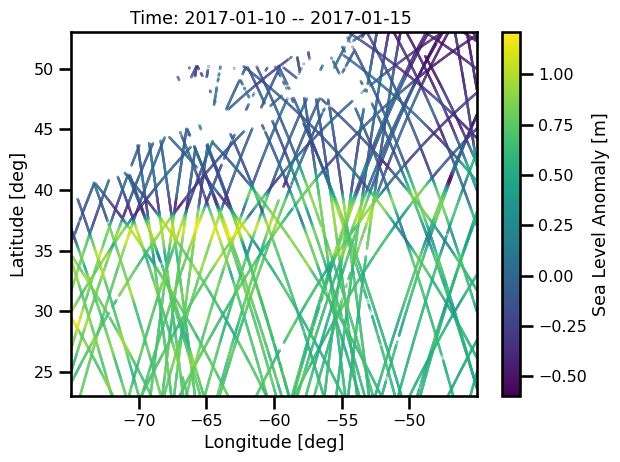

In [75]:
%matplotlib inline

fig, ax = plt.subplots()

t0 = "2017-01-10"
t1 = "2017-01-15"

sub_ds = ds_nadir.sel(time=slice(t0,t1))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude [deg]",
    ylabel="Latitude [deg]",
    xlim=[ds_nadir.lon.min(), ds_nadir.lon.max()],
    ylim=[ds_nadir.lat.min(), ds_nadir.lat.max()],
)

plt.colorbar(pts, label="Sea Level Anomaly [m]")
ax.set_title(f"Time: {t0} -- {t1} ")
plt.tight_layout()
plt.show()